In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144
matplotlib.rcParams['figure.figsize'] = (15,10)
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['lines.markersize'] = 15

# Importing and exploring a build-in Dataset

In [2]:
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
print("Number of entries: {0}".format(diabetes.data.shape[0]))
print("Number of variables: {0}".format(diabetes.data.shape[1]))

Number of entries: 442
Number of variables: 10


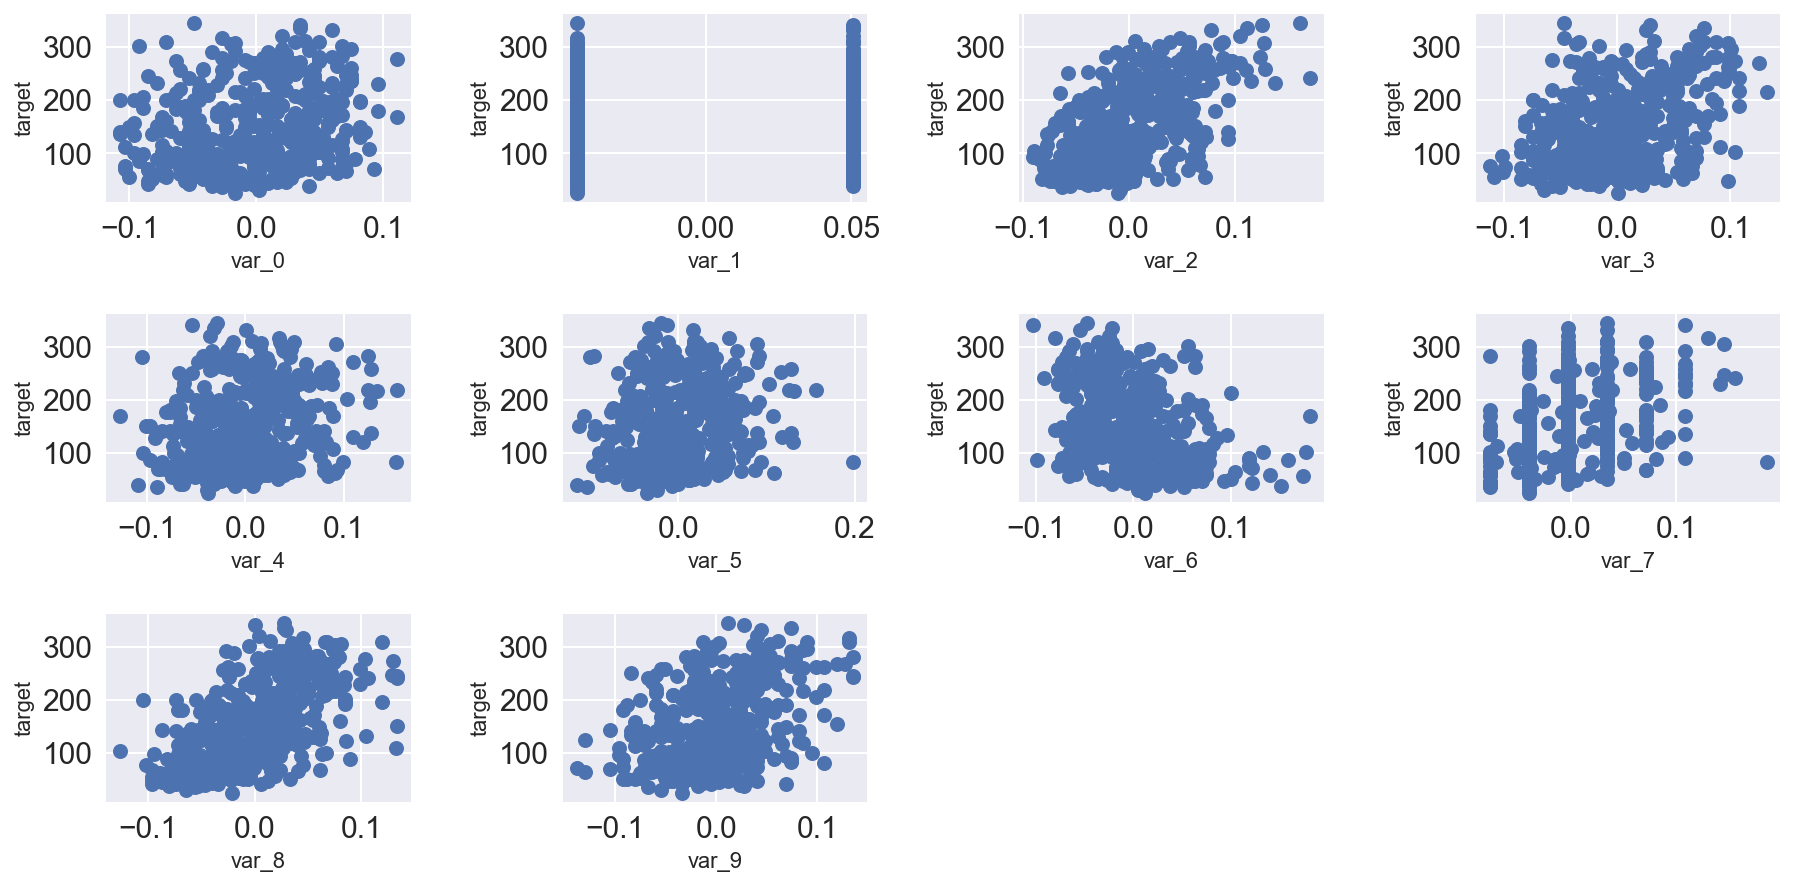

In [3]:
plt.subplots_adjust(wspace=0.5, hspace=0.6)

for var_idx in xrange(diabetes.data.shape[1]):
    plt.subplot(4,4, var_idx+1)
    plt.plot(diabetes.data[:,var_idx], diabetes.target, '.')
    plt.xlabel('var_{0}'.format(var_idx))
    plt.ylabel('target')

# Simple linear fit

/Users/Yak52/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(353,) (353,)
(353, 1) (353,)
The fitted coefficients are: [ 901.23555388]
The fitted intercept are: 152.640637367
R^2 = 0.382696246431


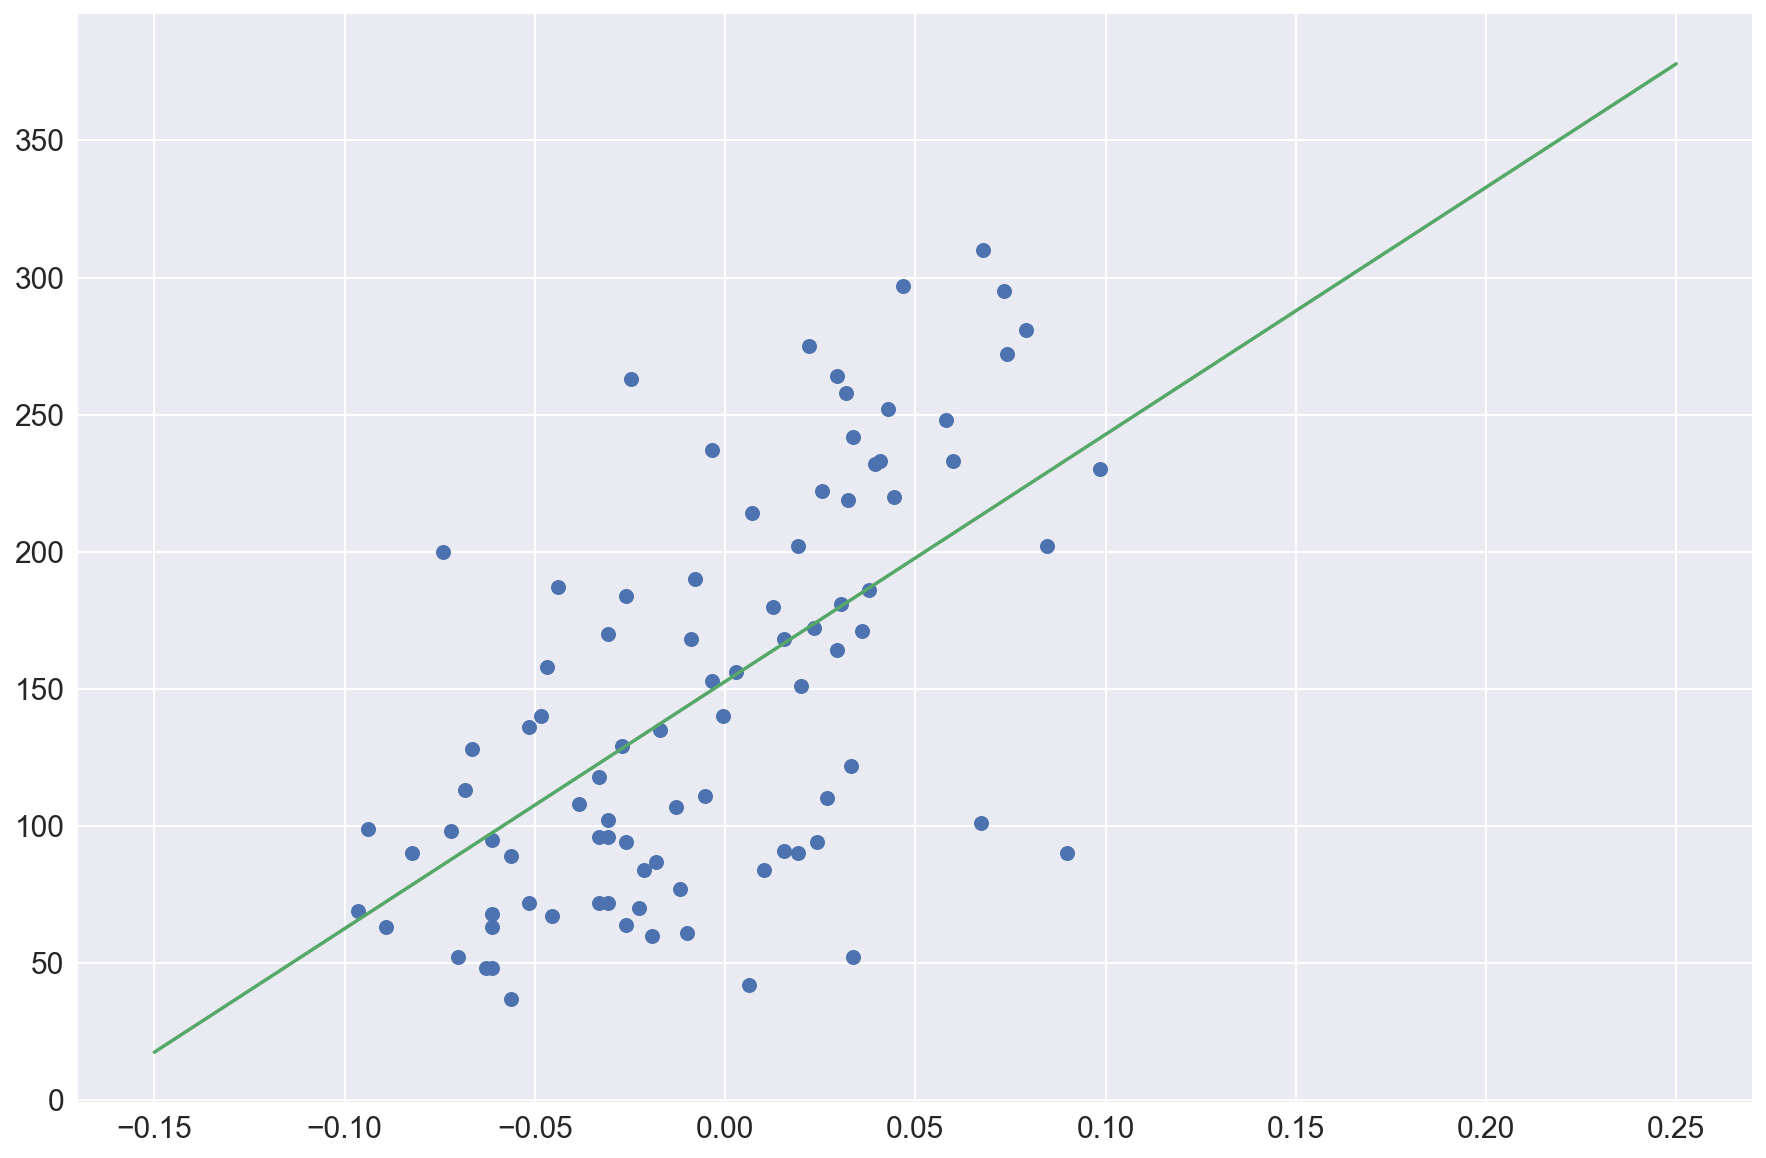

In [4]:
# var_8 shows the best correlation with the target variable. 
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

# Splitting the data-set in training and test sample
X_train, X_test, y_train, y_test = train_test_split(diabetes.data[:,8], diabetes.target, test_size=0.2, random_state=42)

# the shape here for the x is not properly set.
# By default X is a matrix(n_entries,n_features), when
# working with only 1 variable the n_features is not set.
# This would cause a crash when any methods (i.e. LinearRegression.fit)
# will try to access x.shape[1]
print X_train.shape,y_train.shape

# The trick here is to create a new axis so that
# now the x is a matrix(n_entries,1)
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]
print X_train.shape,y_train.shape


lin_mod = LinearRegression(fit_intercept=True)
lin_mod.fit(X_train,y_train)

x_line = np.linspace(-0.15,0.25,100)
y_pred = lin_mod.predict(x_line[:, np.newaxis])
# matplotlib.rcParams['figure.figsize'] = (10,7)

plt.plot(X_test,y_test,'.')
plt.plot(x_line,y_pred,'-')

print("The fitted coefficients are: {0}".format(str(lin_mod.coef_)))
print("The fitted intercept are: {0}".format(str(lin_mod.intercept_)))
print("R^2 = {0}".format(lin_mod.score(X_test,y_test)))



# Simple variable scoring

In [5]:
# Here we select only variable 8 which shows a good linear dependence on the target
# and variable 0 which instead looks almost independent on the target
# Splitting the data-set in training and test sample
X_train, X_test, y_train, y_test = train_test_split(diabetes.data[:,[0,8]], diabetes.target, test_size=0.2, random_state=42)

lin_mod = LinearRegression(fit_intercept=True)
lin_mod.fit(X_train,y_train)

print("The fitted coefficients are: {0}".format(str(lin_mod.coef_)))
print("The fitted intercept are: {0}".format(str(lin_mod.intercept_)))
print("R^2 = {0}".format(lin_mod.score(X_test,y_test)))

# The R^2 score is actually reduced by the introduction of var_0 in the fit
# The coefficient corresponding to var_0 is 10 times smaller than the one
# corresponding to var_8. This can lead to the conclusion that
# var_8 is more strongly related to the target than var_0
# WARNING: this doesn't imply that the target is CAUSED by var_8
# but only that it is correlated with var_8!!!

The fitted coefficients are: [  87.67327022  878.43696284]
The fitted intercept are: 152.54195257
R^2 = 0.377168189492


In [6]:
# Now we introduce in the model also var_2 which as well as var_8 looks
# well correlated to the target 
# Splitting the data-set in training and test sample
X_train, X_test, y_train, y_test = train_test_split(diabetes.data[:,[0,2,8]], diabetes.target, test_size=0.2, random_state=42)

lin_mod = LinearRegression(fit_intercept=True)
lin_mod.fit(X_train,y_train)

print("The fitted coefficients are: {0}".format(str(lin_mod.coef_)))
print("The fitted intercept are: {0}".format(str(lin_mod.intercept_)))
print("R^2 = {0}".format(lin_mod.score(X_test,y_test)))
# Now R^2 increases with respect to the case where we use only var_8.
# From the analysis of the coefficients we can see how var_2 seems to be
# the most correlated variable to the target, followed by var_8, while 
# var_0 as before, is still very weekly correlated to the target

The fitted coefficients are: [  40.41749978  729.1173662   553.10236723]
The fitted intercept are: 151.740196013
R^2 = 0.4488404937


# Transforming input variables

Often before running a machine-learning algorithm data has to be prepared, pre-processed and transformed. In `sklearn` you can find a variety of ready-to-use classes to apply many different transformation to the data. Nevertheless it offen happen that, after exploring the data, you might need to transform the data in a way that is not standard and therefore is not part of the build-in transformations available in `sklearn`. For these cases `sklearn` exposes a set of [classes](http://scikit-learn.org/stable/modules/classes.html) that can be overwritten and adapted to specific problems. The `sklearn` classes responsible of data pre-processing and transformation are called `Transformers`.  They inherit from the baseEstimator and from the TransformerMixin classes and the abstract interface for a generic `Transformer` is:
``` python
class Transformer(base.BaseEstimator, base.TransformerMixin):
  def __init__(self, ...):
    # initialization code
    
  def fit(self, X, y=None):
    # fit the transformation
    return self
  
  def transform(self, X):
    return ... # transformation
```

A comprehensive `.fit_transform` is implemented based on the `.fit` and `.transform` methods in `base.TransformerMixin` ([docs](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html)). However, especially for transformers, `.fit` is often empty and only `.transform` actually does something.


### Simple transformer: shifting a column to have mean equal to 0

In [13]:
class ShiftMeanTransformer(sk.base.BaseEstimator, sk.base.TransformerMixin):
  def __init__(self,target_mean = 0.):
    # initialization code
    self.target = target_mean
    self.actual_ds_mean = None

  def fit(self, X, y=None):
    if X.shape[0] == 0:
        print("WARNING: fitting a null dataset")
        return self
    
    self.actual_ds_mean = X.mean(axis=0)
    # fit the transformation
    return self

  def transform(self, X, y=None):
    return X - self.actual_ds_mean + self.target

var_0_mean = -3.63962254e-16
var_0_transformed_mean = 10.0


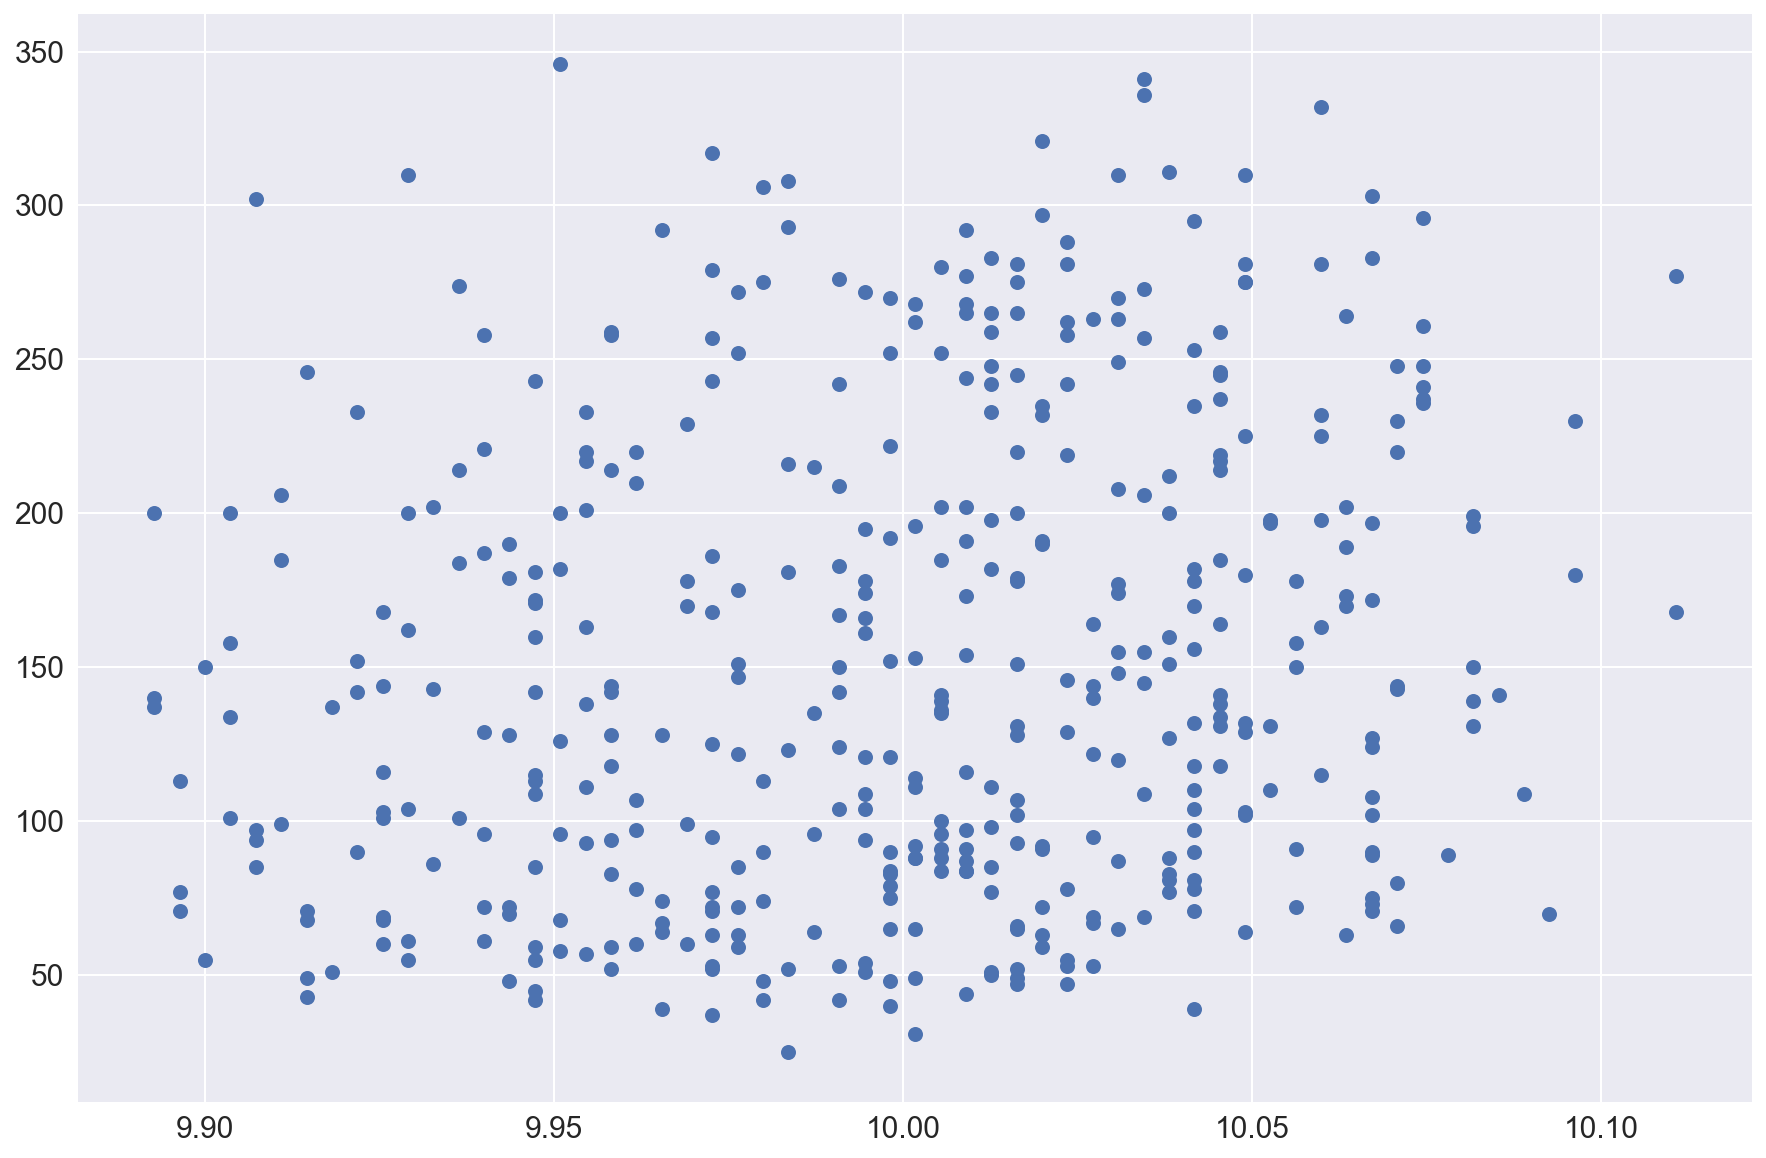

In [14]:
# Now we can try to shift var_0 to have mean = 10
mean_shifter = ShiftMeanTransformer(10)

var_0_transformed = mean_shifter.fit_transform(diabetes.data[:,0])

print("var_0_mean = {0}".format(diabetes.data[:,0].mean(axis=0)))
print("var_0_transformed_mean = {0}".format(var_0_transformed.mean(axis=0)))

plt.plot(var_0_transformed,diabetes.target,'.')


# Building custom Estimators

As well as for the data manipulation, it is also possible to create a custom <i>regressor</i> or <i>classifier</i>. The way how this is possible inside `sklearn` is equivalent to the one to create a custom `Transformer` which in this case is called `Estimator`. 
All estimators (e.g. linear regression, kmeans, etc ...) support `fit` and `predict` methods.  In fact, you can build your own by inheriting from classes in `sklearn.base` by using this template:                                                                                                 
``` python                                                                                                                                        
class Estimator(base.BaseEstimator, base.RegressorMixin):
  def __init__(self, ...):
    # initialization code
  
  def fit(self, X, y):
    # fit the model ...
    return self
    
  def predict(self, X):
    return # prediction
    
  def score(self, X, y):
    return # custom score implementation
```

### Simple Estimator: always predict the average

In [15]:
class MeanEstimator(sk.base.BaseEstimator, sk.base.RegressorMixin):
  def __init__(self,name = 'my_name'):
    # initialization code
    self.name = name
    self.mean = None

  def fit(self, X, y):
    # fit the model ...
    self.mean = y.mean(axis = 0)
    return self

  def predict(self, X):
    return np.full(X.shape,self.mean)

  def score(self, X, y):
    return sk.metrics.r2_score(X,y)


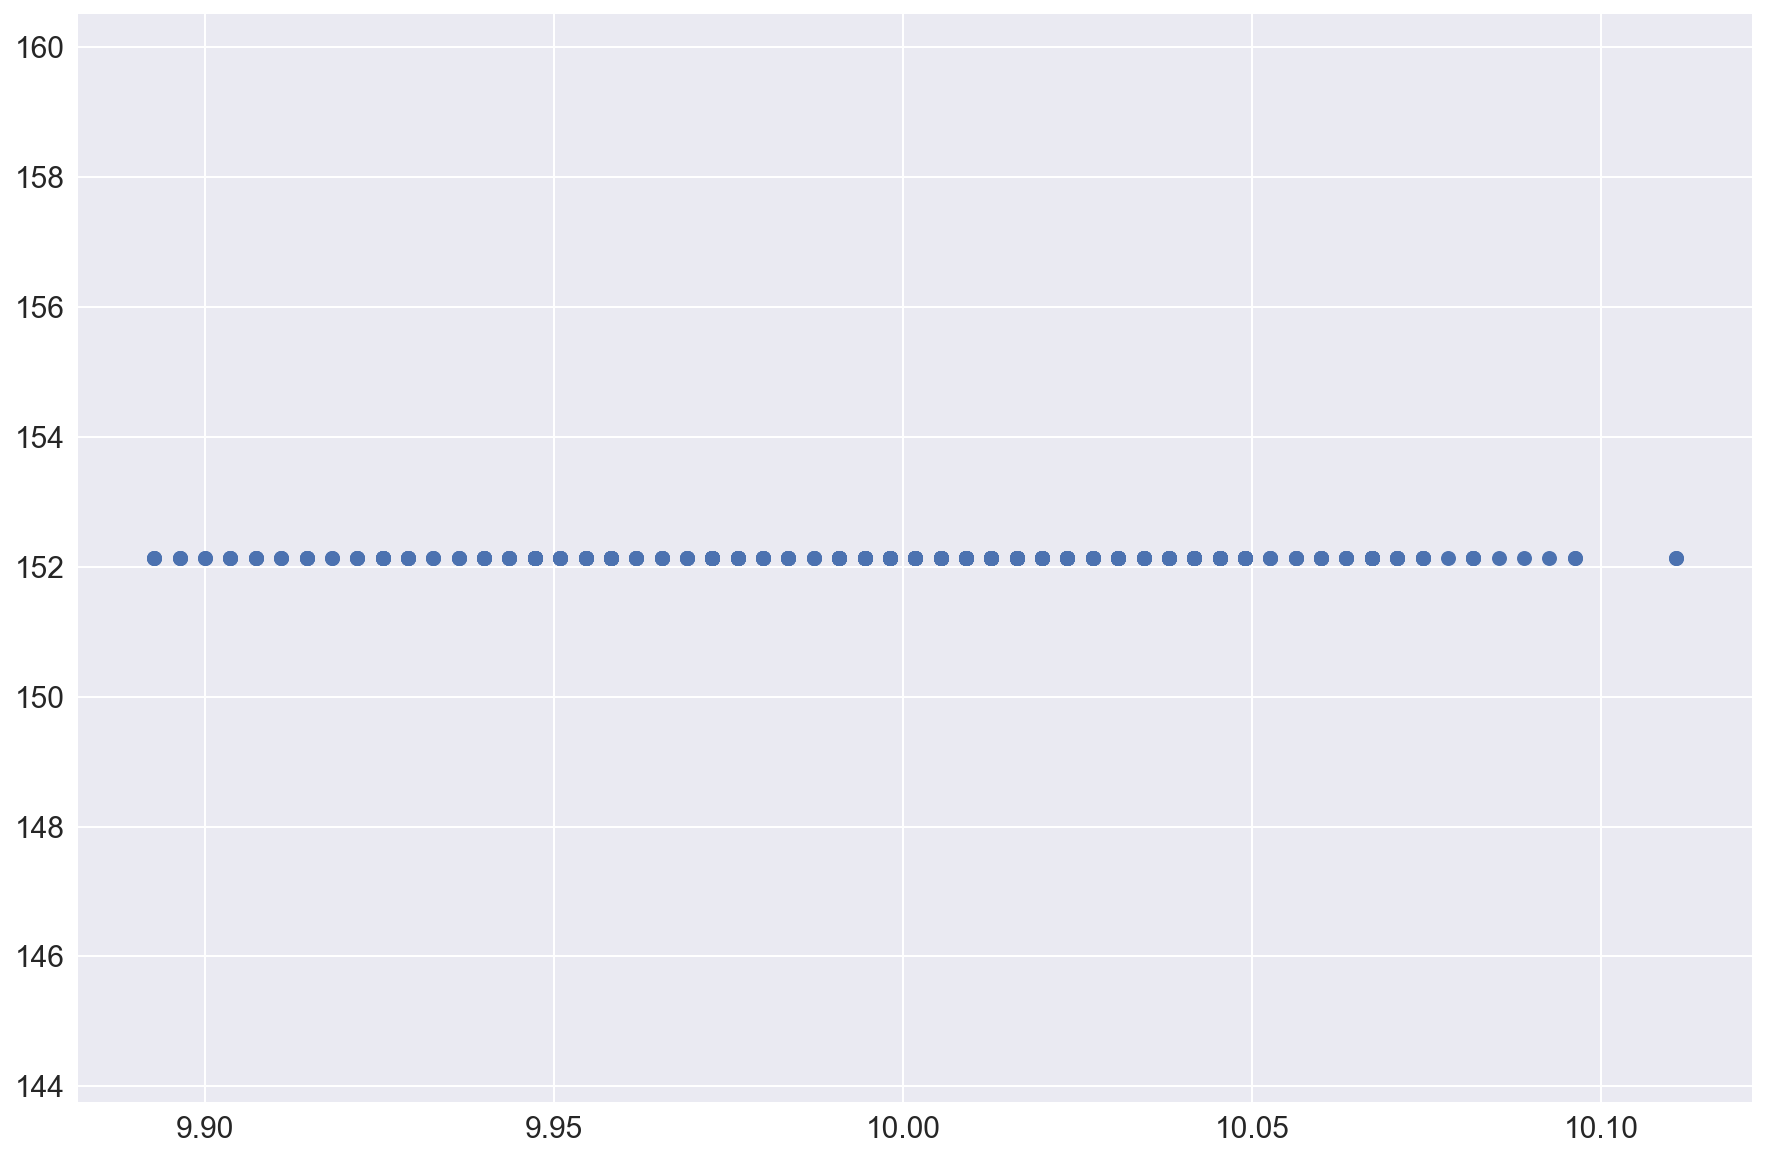

In [16]:
dummy_model = MeanEstimator("no_so_clever")

dummy_model.fit(var_0_transformed,diabetes.target)

dummy_prediction = dummy_model.predict(var_0_transformed)

plt.plot(var_0_transformed,dummy_prediction,'.')